In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_1:oracle.run1",
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 2625], examples_per_second: 659.8473, train_label_loss: 2.7728, 


epoch: 1, [batch: 263 / 2625], examples_per_second: 11950.3079, train_label_loss: 2.2749, 


epoch: 1, [batch: 525 / 2625], examples_per_second: 11794.8598, train_label_loss: 2.0799, 


epoch: 1, [batch: 788 / 2625], examples_per_second: 11714.6518, train_label_loss: 1.9250, 


epoch: 1, [batch: 1050 / 2625], examples_per_second: 11695.1715, train_label_loss: 1.6562, 


epoch: 1, [batch: 1313 / 2625], examples_per_second: 11740.6550, train_label_loss: 1.6432, 


epoch: 1, [batch: 1575 / 2625], examples_per_second: 11647.7948, train_label_loss: 1.6343, 


epoch: 1, [batch: 1837 / 2625], examples_per_second: 11679.9258, train_label_loss: 1.3334, 


epoch: 1, [batch: 2100 / 2625], examples_per_second: 11641.7628, train_label_loss: 1.1439, 


epoch: 1, [batch: 2362 / 2625], examples_per_second: 12009.9114, train_label_loss: 1.1322, 


epoch: 1, source_val_acc_label: 0.6162, source_val_label_loss: 1.1402, target_val_acc_label: 0.0609, target_val_label_loss: 6.8715, 


New best
epoch: 2, [batch: 1 / 2625], examples_per_second: 24.9501, train_label_loss: 1.2298, 


epoch: 2, [batch: 263 / 2625], examples_per_second: 10679.9990, train_label_loss: 0.8865, 


epoch: 2, [batch: 525 / 2625], examples_per_second: 10738.9135, train_label_loss: 0.9789, 


epoch: 2, [batch: 788 / 2625], examples_per_second: 10766.9089, train_label_loss: 0.9103, 


epoch: 2, [batch: 1050 / 2625], examples_per_second: 10760.8835, train_label_loss: 0.8406, 


epoch: 2, [batch: 1313 / 2625], examples_per_second: 10662.5501, train_label_loss: 0.8324, 


epoch: 2, [batch: 1575 / 2625], examples_per_second: 10690.0775, train_label_loss: 0.7856, 


epoch: 2, [batch: 1837 / 2625], examples_per_second: 10749.0633, train_label_loss: 0.6752, 


epoch: 2, [batch: 2100 / 2625], examples_per_second: 10700.5352, train_label_loss: 0.6894, 


epoch: 2, [batch: 2362 / 2625], examples_per_second: 10720.2887, train_label_loss: 0.6968, 


epoch: 2, source_val_acc_label: 0.7992, source_val_label_loss: 0.6138, target_val_acc_label: 0.0786, target_val_label_loss: 10.5387, 


New best
epoch: 3, [batch: 1 / 2625], examples_per_second: 26.2248, train_label_loss: 0.5057, 


epoch: 3, [batch: 263 / 2625], examples_per_second: 11732.3296, train_label_loss: 0.5451, 


epoch: 3, [batch: 525 / 2625], examples_per_second: 11757.1686, train_label_loss: 0.7163, 


epoch: 3, [batch: 788 / 2625], examples_per_second: 11567.9865, train_label_loss: 0.8332, 


epoch: 3, [batch: 1050 / 2625], examples_per_second: 11749.3523, train_label_loss: 0.6134, 


epoch: 3, [batch: 1313 / 2625], examples_per_second: 11810.2951, train_label_loss: 0.7050, 


epoch: 3, [batch: 1575 / 2625], examples_per_second: 11683.2253, train_label_loss: 0.5740, 


epoch: 3, [batch: 1837 / 2625], examples_per_second: 11751.3351, train_label_loss: 0.5408, 


epoch: 3, [batch: 2100 / 2625], examples_per_second: 11795.3322, train_label_loss: 0.4346, 


epoch: 3, [batch: 2362 / 2625], examples_per_second: 11788.1283, train_label_loss: 0.4517, 


epoch: 3, source_val_acc_label: 0.7585, source_val_label_loss: 0.6373, target_val_acc_label: 0.0821, target_val_label_loss: 12.4615, 


New best
epoch: 4, [batch: 1 / 2625], examples_per_second: 29.2076, train_label_loss: 0.7260, 


epoch: 4, [batch: 263 / 2625], examples_per_second: 11950.0551, train_label_loss: 0.4298, 


epoch: 4, [batch: 525 / 2625], examples_per_second: 11767.7947, train_label_loss: 0.4514, 


epoch: 4, [batch: 788 / 2625], examples_per_second: 11687.5358, train_label_loss: 0.5820, 


epoch: 4, [batch: 1050 / 2625], examples_per_second: 11640.8350, train_label_loss: 0.3577, 


epoch: 4, [batch: 1313 / 2625], examples_per_second: 11682.6794, train_label_loss: 0.3398, 


epoch: 4, [batch: 1575 / 2625], examples_per_second: 11883.4620, train_label_loss: 0.4816, 


epoch: 4, [batch: 1837 / 2625], examples_per_second: 11657.3486, train_label_loss: 0.4277, 


epoch: 4, [batch: 2100 / 2625], examples_per_second: 11704.1353, train_label_loss: 0.4229, 


epoch: 4, [batch: 2362 / 2625], examples_per_second: 12776.2828, train_label_loss: 0.4854, 


epoch: 4, source_val_acc_label: 0.8393, source_val_label_loss: 0.4374, target_val_acc_label: 0.0666, target_val_label_loss: 14.6153, 


epoch: 5, [batch: 1 / 2625], examples_per_second: 32.8555, train_label_loss: 0.3433, 


epoch: 5, [batch: 263 / 2625], examples_per_second: 13268.6390, train_label_loss: 0.3661, 


epoch: 5, [batch: 525 / 2625], examples_per_second: 12886.9721, train_label_loss: 0.3632, 


epoch: 5, [batch: 788 / 2625], examples_per_second: 12890.7146, train_label_loss: 0.4399, 


epoch: 5, [batch: 1050 / 2625], examples_per_second: 12889.5181, train_label_loss: 0.3420, 


epoch: 5, [batch: 1313 / 2625], examples_per_second: 12942.7436, train_label_loss: 0.3411, 


epoch: 5, [batch: 1575 / 2625], examples_per_second: 12807.9529, train_label_loss: 0.5956, 


epoch: 5, [batch: 1837 / 2625], examples_per_second: 12974.4226, train_label_loss: 0.5175, 


epoch: 5, [batch: 2100 / 2625], examples_per_second: 12732.3304, train_label_loss: 0.4071, 


epoch: 5, [batch: 2362 / 2625], examples_per_second: 13874.3315, train_label_loss: 0.3586, 


epoch: 5, source_val_acc_label: 0.8423, source_val_label_loss: 0.4157, target_val_acc_label: 0.0712, target_val_label_loss: 15.5941, 


epoch: 6, [batch: 1 / 2625], examples_per_second: 29.2862, train_label_loss: 0.4280, 


epoch: 6, [batch: 263 / 2625], examples_per_second: 11765.5947, train_label_loss: 0.2588, 


epoch: 6, [batch: 525 / 2625], examples_per_second: 12069.8339, train_label_loss: 0.3488, 


epoch: 6, [batch: 788 / 2625], examples_per_second: 11726.4532, train_label_loss: 0.3845, 


epoch: 6, [batch: 1050 / 2625], examples_per_second: 11719.8894, train_label_loss: 0.2750, 


epoch: 6, [batch: 1313 / 2625], examples_per_second: 11788.6070, train_label_loss: 0.2777, 


epoch: 6, [batch: 1575 / 2625], examples_per_second: 11797.9910, train_label_loss: 0.2948, 


epoch: 6, [batch: 1837 / 2625], examples_per_second: 11814.5270, train_label_loss: 0.2628, 


epoch: 6, [batch: 2100 / 2625], examples_per_second: 11712.0311, train_label_loss: 0.3703, 


epoch: 6, [batch: 2362 / 2625], examples_per_second: 11760.4283, train_label_loss: 0.2524, 


epoch: 6, source_val_acc_label: 0.8355, source_val_label_loss: 0.4240, target_val_acc_label: 0.0714, target_val_label_loss: 17.1680, 


epoch: 7, [batch: 1 / 2625], examples_per_second: 29.1801, train_label_loss: 0.1863, 


epoch: 7, [batch: 263 / 2625], examples_per_second: 11775.0451, train_label_loss: 0.1942, 


epoch: 7, [batch: 525 / 2625], examples_per_second: 11751.5246, train_label_loss: 0.3360, 


epoch: 7, [batch: 788 / 2625], examples_per_second: 11757.1621, train_label_loss: 0.1707, 


epoch: 7, [batch: 1050 / 2625], examples_per_second: 11751.8358, train_label_loss: 0.2393, 


epoch: 7, [batch: 1313 / 2625], examples_per_second: 11718.8978, train_label_loss: 0.4023, 


epoch: 7, [batch: 1575 / 2625], examples_per_second: 11774.8765, train_label_loss: 0.3901, 


epoch: 7, [batch: 1837 / 2625], examples_per_second: 11767.8596, train_label_loss: 0.3162, 


epoch: 7, [batch: 2100 / 2625], examples_per_second: 11798.6331, train_label_loss: 0.2783, 


epoch: 7, [batch: 2362 / 2625], examples_per_second: 11793.9223, train_label_loss: 0.2552, 


epoch: 7, source_val_acc_label: 0.8115, source_val_label_loss: 0.4958, target_val_acc_label: 0.0576, target_val_label_loss: 18.7400, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

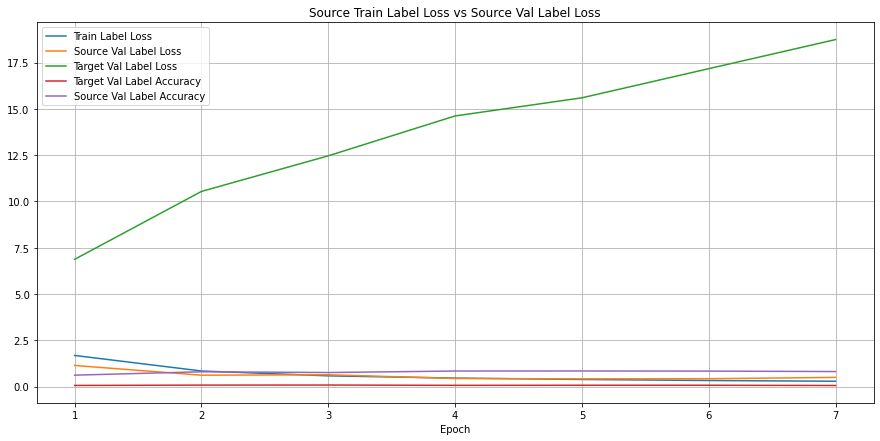

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

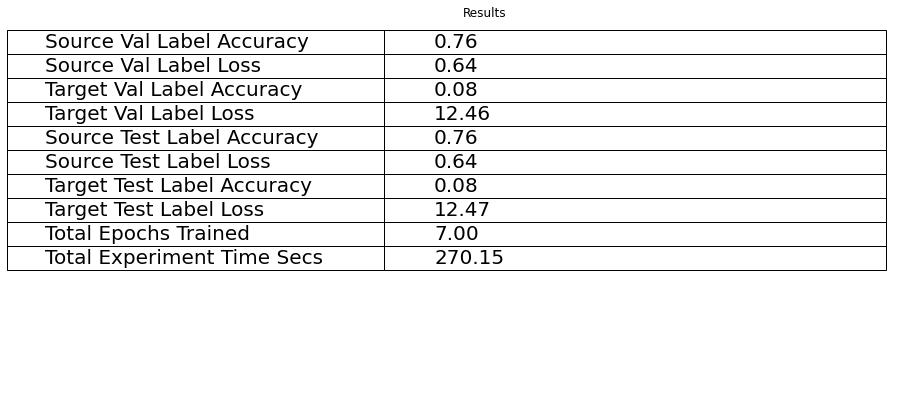

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

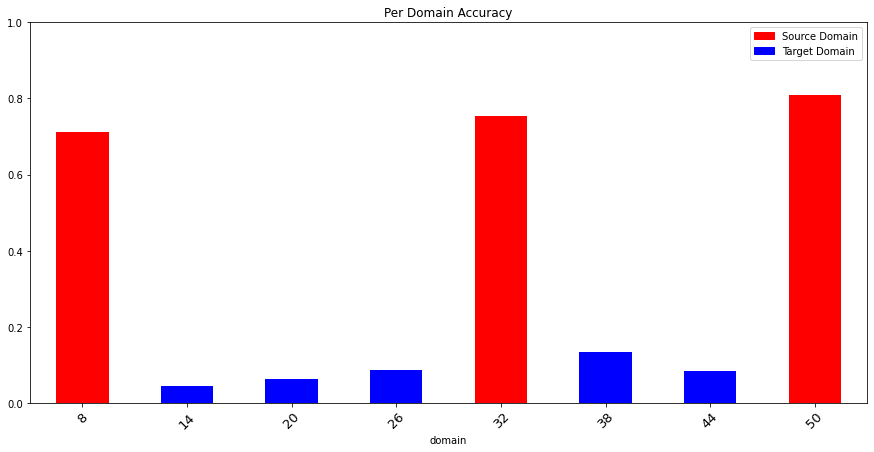

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7573194444444444 Target Test Label Accuracy: 0.08258333333333333
Source Val Label Accuracy: 0.7584861111111111 Target Val Label Accuracy: 0.08210833333333334


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_1:oracle.run1", "parameters": {"experiment_name": "cnn_1:oracle.run1", "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding"